## This Notebook produces the graphs used in the DMDEnKF paper for modelling seasonal influenza-like illness with the DMDEnKF

### First import the relevant dependencies, and set the plotting properties

In [1]:
#IMPORT DEPENDENCIES
from DMDEnKF.classes.ilinetdata import ILINetData,LogTransform, ModellingChoices
from DMDEnKF.classes.DMDEnKF import TDMD
import DMDEnKF.helper_functions.ili_applications_functions as iaf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sb
import cmath
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.decomposition import PCA

#Set matplotlib settings as required
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Set parameters for the data's csv location, and relevant modelling choices

In [2]:
#Set Key Parameters

#IMPORT THE DATA
ilinet = ILINetData('data/american_flu/ILINet.csv')

#set disease name here to save having to change multiple times
disease = 'Influenza-like illness'

#set relevant modelling choice parameters

#data input is ilinet (not RCGP)
data = ilinet
#set covariances for filtering section
#(system_cov = 1, obs_cov = sys_obs_rat**2, eig_cov = sys_eig_rat**2)
sys_cov_rat = 0.5
sys_obs_rat = 0.5
sys_eig_rat = 0.01

#Note: excluding pandemic years/ flu season weeks may no longer be compatible with later code
#set any years to exclude
#pandemic_years = [2009]
pandemic_years = None
#set weeks to exclude
#flu_season = [1,2,3,4,5,6,7,8,9,10,11,12,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52]
flu_season = None
#set data transform
#log is chosen transform, and needs constant to deal with 0 values
logconst = 1
logtrans= LogTransform(constant=logconst)
data_transform = logtrans
#set point to split data into train/test
datetime_to_split = datetime.datetime(2012, 1, 1,)

#set max number of steps ahead to predict
n_steps_max = 12
#set hankel dim
hankel_dim = 1

#initialise random seed
np.random.seed(0)

### Train the spin-up DMD model, run the filtering section of the DMDEnKF, and generate forecasts

In [3]:
#Train and run filter over the data

#initialise modelling choices object - children classes used to modularise new methodological variations
m = ModellingChoices(data_transform=data_transform, pandemic_years=pandemic_years,flu_season=flu_season)

#prepare the data in a way determined by the above parameters and split to spin up/filter
m.prepare_data(data,disease,datetime_to_split,hankel_dim=hankel_dim)

#initialise and run TDMD on spin up data that comes in discontinuous form
f = TDMD()
f.fit(data=m.spinup_transformed_stratified_data,datatype='discontinuous',r=8)

#run the filter over the rest of the data, carrying the eigenvalue estimates over from each discontinuous section
m.filter_all_sections(f,eig_carry=True,sys_obs_rat=sys_obs_rat,sys_eig_rat=sys_eig_rat, sys_cov_rat=sys_cov_rat)

#set relevant variables names using modelling choices object
dmdenkf = m.dmdenkf_container['full_filters'][0]
#forecast using the DMDEnKF
df = iaf.generate_forecast_df(dmdenkf,m,n_steps_max)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


2


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


3


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


4


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


5


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


6


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


7


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


8


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


9


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


10


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


11


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


12


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


### Plot the real, total ILI consultation data to show what we are trying to fit to

Text(0.5, 0, 'Date')

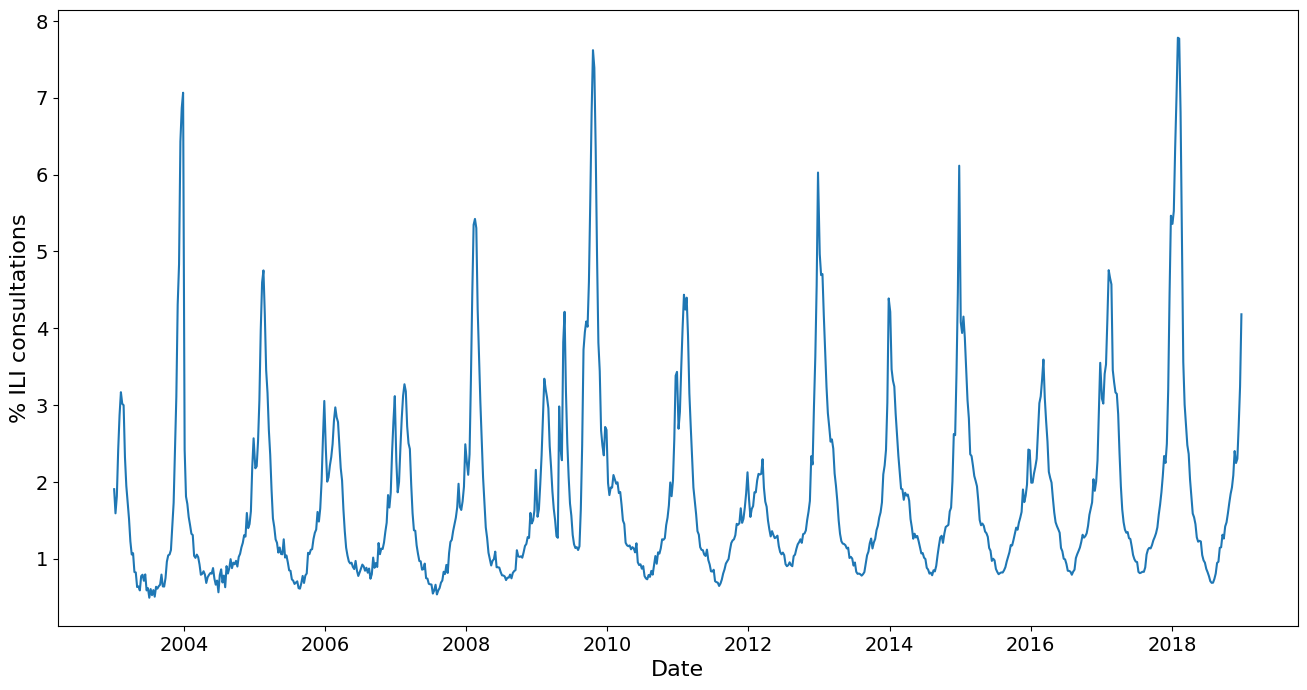

In [4]:
#Plot ILI True Data
#ILI consultations as a percentage of total weekly GP consultations from 2003 to end of 2018.
plt.plot(df['total data'],color='tab:blue',label='Real Data',zorder=-1)
plt.ylabel('% ILI consultations')
plt.xlabel('Date')
#plt.savefig('graphs/ILI_true_data.png',bbox_inches='tight')

### Plot the transformed, stratified data, to show what data is actually going into the DMD algorithm

Text(444, 42.5, 'Spin Up \n Split')

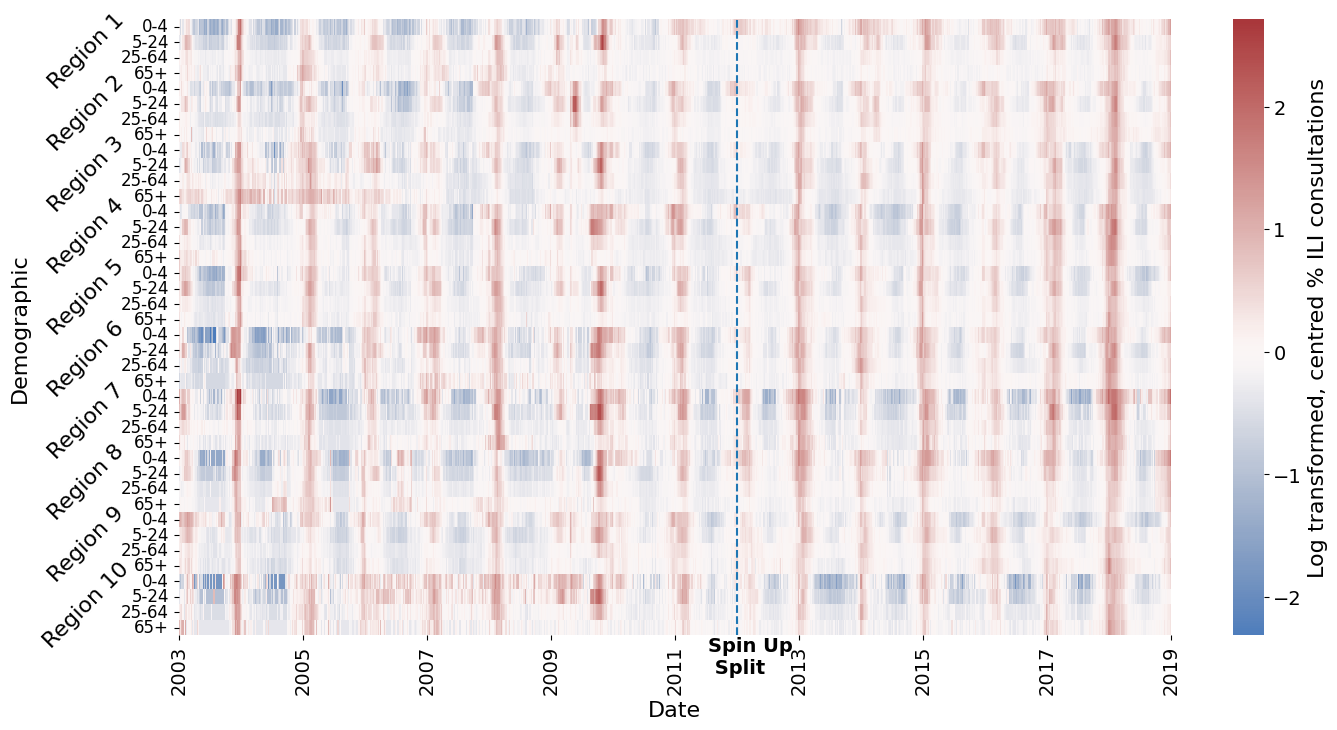

In [5]:
#Plot Transformed Demographic Data
#ILI consultations as a percentage of total weekly GP consultations for each demographic, log transformed and centred.

#set x ticks to be appropriately spread out
ticks = [ilinet.x_values[i] for i in range(0,len(ilinet.x_values),104)]
ticks.append(ilinet.x_values[-1] + datetime.timedelta(weeks=1))

#recombine train/test data
tran_data = np.hstack([m.spinup_transformed_stratified_data[0],m.transformed_stratified_data[0]])

#set y ticks to be appropriately named
regions = ['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5',
           'Region 6', 'Region 7', 'Region 8', 'Region 9', 'Region 10']
ages = ['0-4', '5-24', '25-64', '65+']
reg_age = [[f'{region} 0-4']+ages[1:]  for region in regions]
reg_age = [l for sub in reg_age for l in sub]

#generate heatmap
sb.heatmap(tran_data,cmap='vlag',center=0,cbar_kws={'label': 'Log transformed, centred % ILI consultations'},
          yticklabels=ages*10)

#add plot details
plt.xlabel('Date',fontdict={'size':MEDIUM_SIZE})
plt.ylabel('Demographic',fontdict={'size':MEDIUM_SIZE})

#wizardry to get y ticks setup
ax1 = plt.gca()
ax1.set_yticklabels(ages*10,fontsize=12)
ax1.yaxis.set_label_coords(-0.15,0.5)
for i,region in enumerate(regions):
    ax2 = plt.gca().twinx()
    ax2.set_ylabel(region,rotation=45)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.axes.xaxis.set_ticks([])
    ax2.axes.yaxis.set_ticks([])
    ax2.yaxis.set_label_coords(-0.1, 1-0.04- i*0.1)

#add x ticks
plt.xticks([i for i in range(0,len(ilinet.x_values)+1,104)],labels=[t.year for t in ticks])

#draw train/test divide
ax1.vlines(468, *ax1.get_ylim(),linestyle='--')
ax1.text(444,42.5,'Spin Up \n Split',size=SMALL_SIZE,weight='bold')
#plt.savefig('graphs/transformed_demographic_data.png',bbox_inches='tight')

### Plot the eigenvalues that are generated by the spin-up DMD process

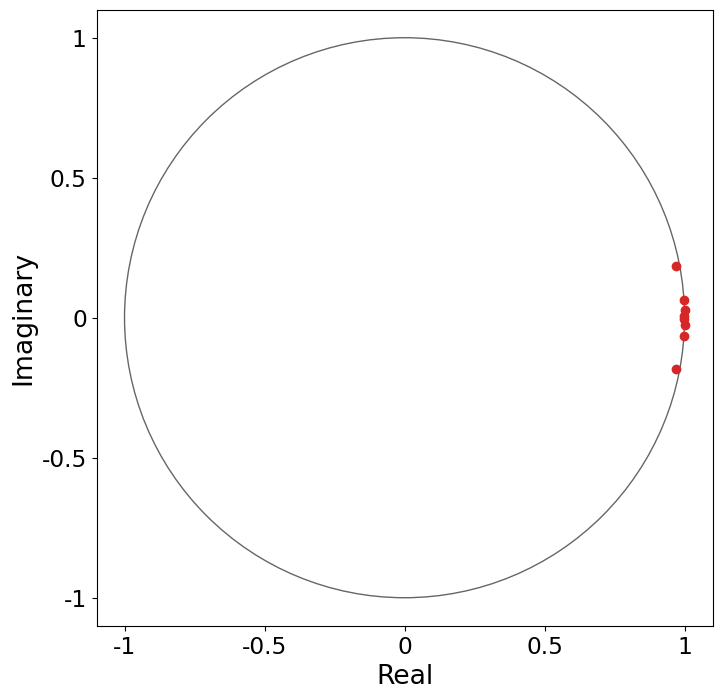

In [6]:
#Plot Spin-up DMD Eigs

#PLOT SETTINGS for smaller plot
plt.rcParams["figure.figsize"] = (8,8) # (w, h)
scaling = 1.2
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#generate eig plot
iaf.gen_eigenvalue_plots(f.E)
#plt.savefig('graphs/spinup_eigs.png',bbox_inches='tight')

### Plot the DMD modes that are generated by the DMD process

Text(0.05, 0.5, 'Ages')

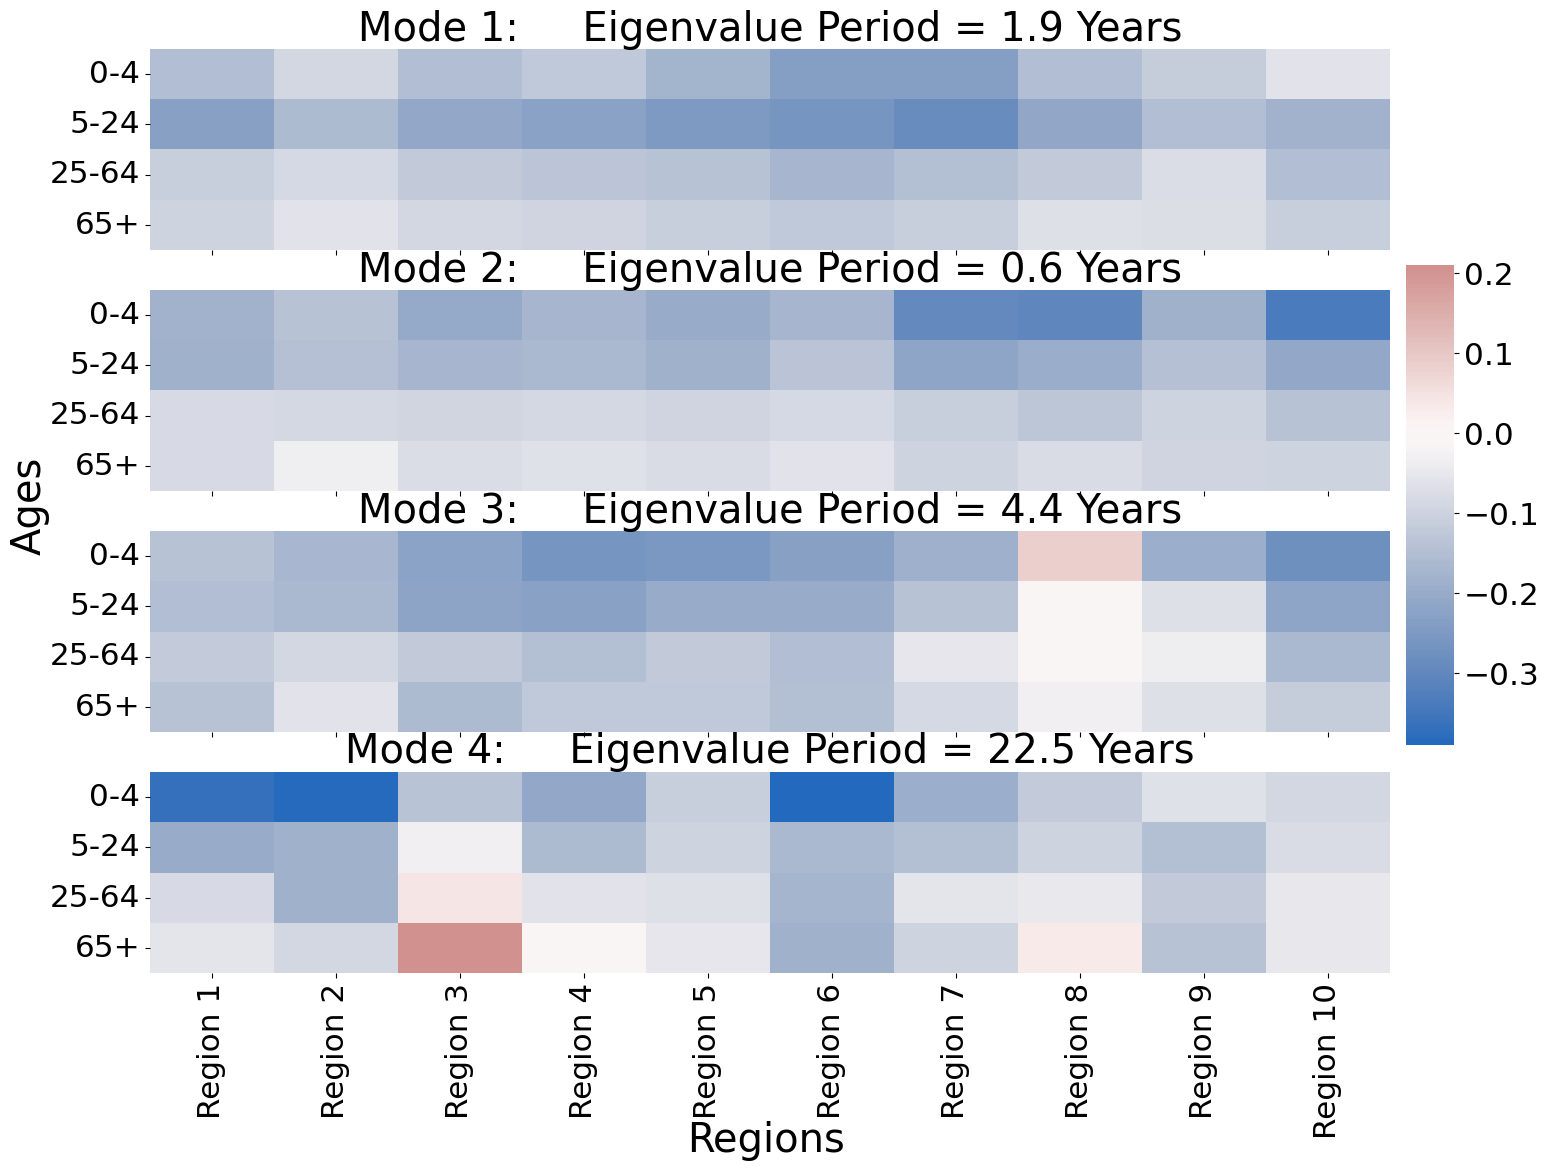

In [7]:
#Create plot of DMD modes
#WARNING - Code works but is very specific to this example so not built to be transferable

#PLOT SETTINGS
plt.rcParams["figure.figsize"] = (16,12) # (w, h)
scaling = 1.6
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#to better interpret the complex DMD modes we rewrite DMD mode solution as:
#2*r1*r2*real_renorming*cos(theta1 + theta2)Re(v) - 2*r1*r2*imag_renorming*sin(theta1 + theta2)Im(v)
#where r1 = complex eigenvalue pair's modulus
#r2 = complex initial state when projected on DMD mode's modulus
#****_renorming = constants such that vectors Re(v) and Im(v) are normalised
#theta1 = complex eigenvalue pair's argument
#theta2 = complex initial state when projected on DMD mode's argument
#Re(v)/Im(v) = the real/imaginairy parts respectively of the complex DMD mode vector (aka the plane of rotation)

#designate each complex DMD mode pair as one reprenting the real and one the imaginary part
#this was filled in knowing that the DMD eigs are consecutive complex conjugate pairs
reals = [True,False,True,False,True,False,True,False]
#calculate ****_renorming consts
mode_norm_consts = [np.linalg.norm(np.real(mod)) if real == True else np.linalg.norm(np.imag(mod))for real,mod in zip(reals,f.DMD_modes.T)]
#calculate relevant modulus and args
r1s = [cmath.polar(mod)[0] for mod in f.E]
r2s = [cmath.polar(mod)[0] for mod in f.DMD_inv_modes@m.transformed_stratified_data[0][:,0]]
theta1s = [cmath.polar(mod)[1] for mod in f.E]
theta2s = [cmath.polar(mod)[1] for mod in f.DMD_inv_modes@m.transformed_stratified_data[0][:,0]]
#generate normalised, real modes
def complex_modes2real(dmd_modes, mode_norm_consts, reals):
    real_format_modes = []
    for mode, mnc, real in zip(dmd_modes.T,mode_norm_consts,reals):
        if real == True:
            real_format_modes.append(np.real(mode)/mnc)
        else:
            real_format_modes.append(np.imag(mode)/mnc)
    return real_format_modes            
realised_modes = np.array(complex_modes2real(f.DMD_modes, mode_norm_consts,reals))
#find average eig modulus and args as these change with filtering
eigs = [x[-f.r:] for x in m.dmdenkf_container['full_filters'][0].X]
average_eigs = np.mean(np.array(eigs),axis=0)
average_r1s = []
average_theta1s = []
for i,e in enumerate(average_eigs):
    if i%2 == 0:
        average_r1s.extend([e,e])
    else:
        average_theta1s.extend([e,e])

#calculate amount of each new real mode in the spin-up data as rough guide to most dominant modes
real_imag_mode_breakdown = [np.real(mod) if real == True else np.imag(mod) for real,mod in zip(reals,f.DMD_inv_modes@m.spinup_transformed_stratified_data[0])]
true_mode_breakdown = [2*mnc*rimb if real == True else -2*mnc*rimb for real,mnc,rimb in zip(reals,mode_norm_consts,real_imag_mode_breakdown)]
mode_data_relevance = np.mean(np.abs(true_mode_breakdown),axis=1)
#sort indexs of interest from most relevant modes
index_of_interest = [list(mode_data_relevance).index(sorted(mode_data_relevance,reverse=True)[i]) for i in range(len(mode_data_relevance))]
#restrict to only 1 mode per conj pair
for i in index_of_interest:
    if i%2 == 0:
        index_of_interest.remove(i+1)
    elif i%2 == 1:
        index_of_interest.remove(i-1)

#DMD modes
#4 most dominant DMD Modes produced by the spin up DMD.
regions = ['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5',
           'Region 6', 'Region 7', 'Region 8', 'Region 9', 'Region 10']
ages = ['0-4', '5-24', '25-64', '65+']
yticks = ages
xticks = regions
modes_of_interest = [realised_modes[i] for i in index_of_interest]
vmax = np.max(modes_of_interest)
vmin = np.min(modes_of_interest)
fig, ax = plt.subplots(nrows=len(index_of_interest),sharey=True,sharex=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i,j in zip(index_of_interest,range(len(index_of_interest))):
    sb.heatmap(np.reshape(realised_modes[i],(10,4)).T,xticklabels=xticks,yticklabels=yticks,ax=ax[j],vmin=vmin,vmax=vmax,cbar_ax=cbar_ax,cmap="vlag",center=0)
    ax[j].title.set_text(f'Mode {j+1}:     Eigenvalue Period = {round(2*np.pi/theta1s[i]/52,1)} Years')
fig.text(0.51, -0.03, 'Regions', ha='center', va='center',size=BIGGER_SIZE)
fig.text(0.05, 0.5, 'Ages', ha='center', va='center', rotation='vertical',size=BIGGER_SIZE)
#plt.savefig(f'graphs/DMD_modes.png',bbox_inches='tight')

### Show how the DMDEnKF forecasts change as new data is assimilated

/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(1.5, 6.5)

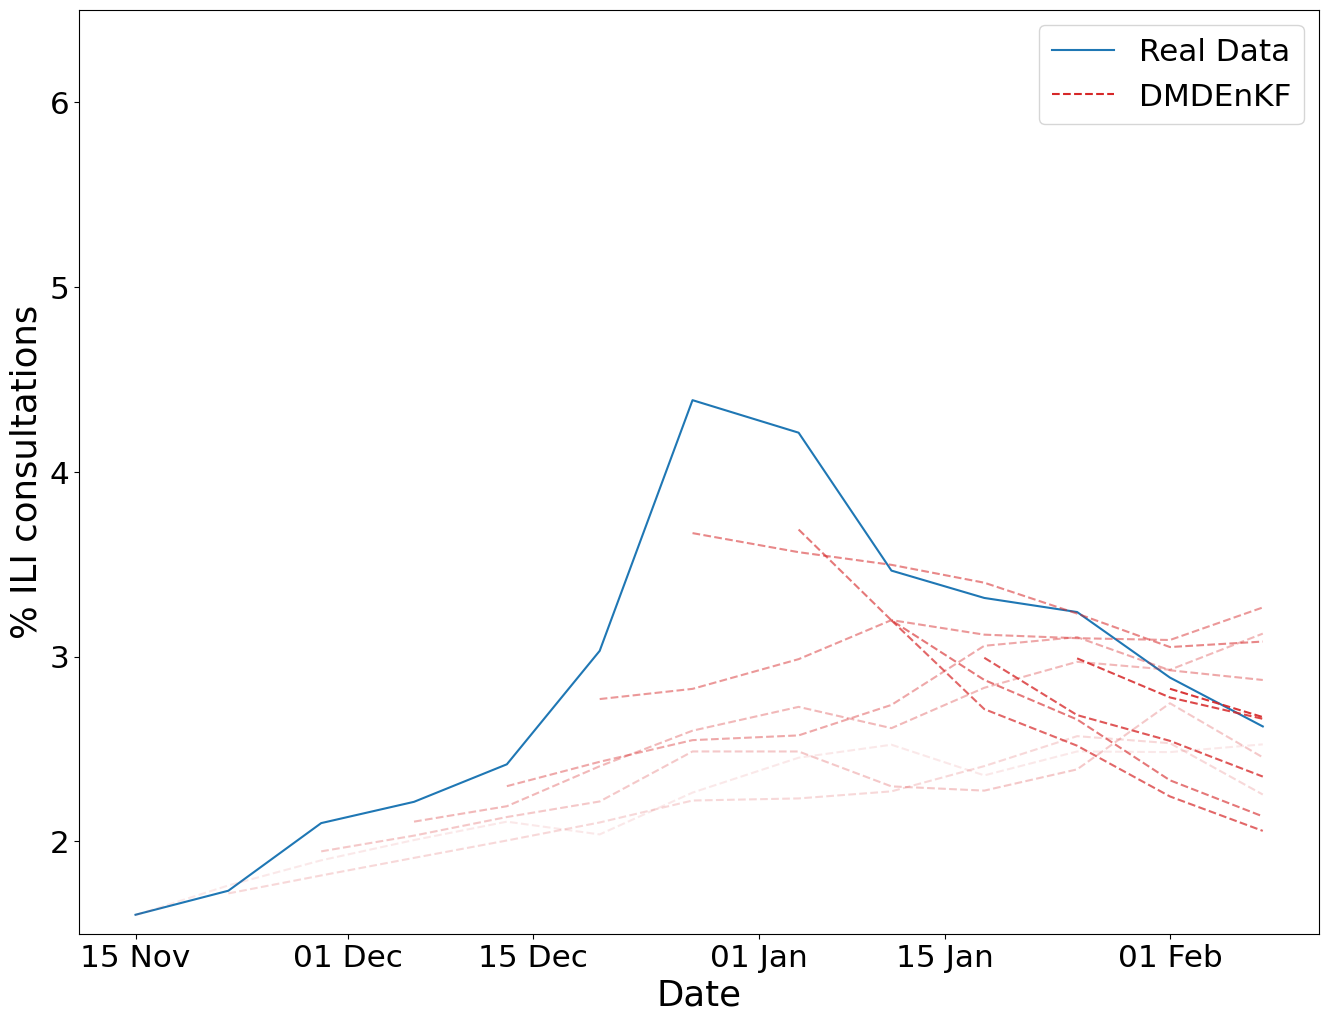

In [8]:
#Enkf Zoom Pred
#DMDEnKF ILI consultation forecasts and how they change as new data is assimilated over the 2013/14 flu season peak.

#total week period to cover (note this must not exceed n_steps_max set at the start of the notebook)
tot_weeks_ahead = 12
#date to start from
date = datetime.datetime(2013,11,15)

#produce relevant plot dates, naive DMD preds and DMDEnKF preds
plot_dates, super_step_preds, super_dmdenkf_preds = iaf.wrapper_gen_step_dmd_preds(date,tot_weeks_ahead,m,dmdenkf,df)

#plot true data
fig,ax = plt.subplots()
plt.plot(df['total data'][date:][:tot_weeks_ahead+1],label='Real Data',color='tab:blue')

#plot in increasing opaqueness the dmdenkf predictions (with only 1 label)
min_alpha = 0.1
for i,dmdo in enumerate(super_dmdenkf_preds):
    alpha = min_alpha + (1-min_alpha)*(i/(len(super_dmdenkf_preds)-1))
    if i == len(super_dmdenkf_preds)-1:
        lab = 'DMDEnKF'
    else:
        lab = None
    #plt.plot(plot_dates,super_step_preds[i], alpha= alpha,color='tab:orange')
    plt.plot(plot_dates,dmdo,alpha= alpha,color='tab:red',linestyle='--',label=lab)

#add plot details
plt.ylabel('% ILI consultations')
plt.xlabel('Date')
plt.legend()

#format the dates in the x ticks correctly
myFmt = mdates.DateFormatter('%d %b')
ax.xaxis.set_major_formatter(myFmt)
#ensure consistent scaling for DMDEnKF and naive DMD preds
plt.ylim(1.5,6.5)
#plt.savefig('graphs/enkf_zoom_pred.png',bbox_inches='tight')

### Show what the naive DMD model would predict as new data is received

(1.5, 6.5)

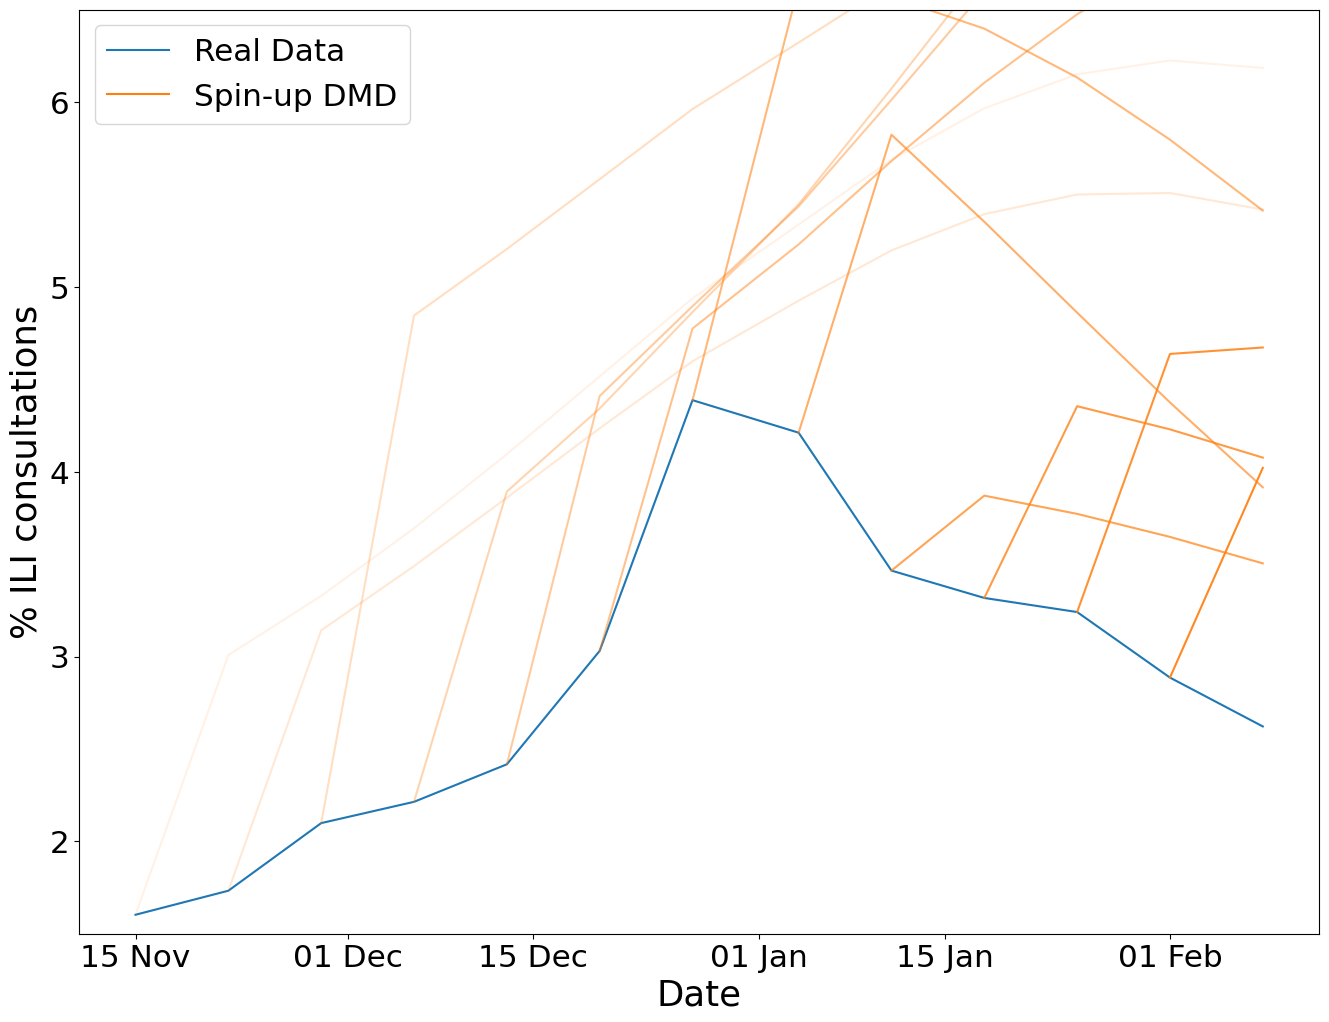

In [9]:
#Step Zoom Pred
#Spin up DMD ILI consultation forecasts and how they change as new data is assimilated over the 2013/14 flu season peak.

#total week period to cover (note this must not exceed n_steps_max set at the start of the notebook)
tot_weeks_ahead = 12
#date to start from
date = datetime.datetime(2013,11,15)

#produce relevant plot dates, naive DMD preds and DMDEnKF preds
plot_dates, super_step_preds, super_dmdenkf_preds = iaf.wrapper_gen_step_dmd_preds(date,tot_weeks_ahead,m,dmdenkf,df)

#plot true data
fig,ax = plt.subplots()
plt.plot(df['total data'][date:][:tot_weeks_ahead+1],label='Real Data',color='tab:blue')

#plot in increasing opaqueness the dmdenkf predictions (with only 1 label)
min_alpha = 0.1
for i,dmdo in enumerate(super_dmdenkf_preds):
    alpha = min_alpha + (1-min_alpha)*(i/(len(super_dmdenkf_preds)-1))
    if i == len(super_dmdenkf_preds)-1:
        lab = 'DMDEnKF'
        lab2 = 'Spin-up DMD'
    else:
        lab = None
        lab2 = None
    plt.plot(plot_dates,super_step_preds[i], alpha= alpha,color='tab:orange', label=lab2)
    #plt.plot(plot_dates,dmdo,alpha= alpha,color='tab:red',linestyle='--',label=lab)

#add plot details
plt.ylabel('% ILI consultations')
plt.xlabel('Date')
plt.legend()

#format the dates in the x ticks correctly
myFmt = mdates.DateFormatter('%d %b')
ax.xaxis.set_major_formatter(myFmt)
#ensure consistent scaling for DMDEnKF and naive DMD preds
plt.ylim(1.5,6.5)
#plt.savefig('graphs/step_zoom_pred.png',bbox_inches='tight')

### Plot the DMD reconstruction over the spin-up period, followed by the DMDEnKF's 4-week ahead forecasts over the remaining data

(0.0, 10.2)

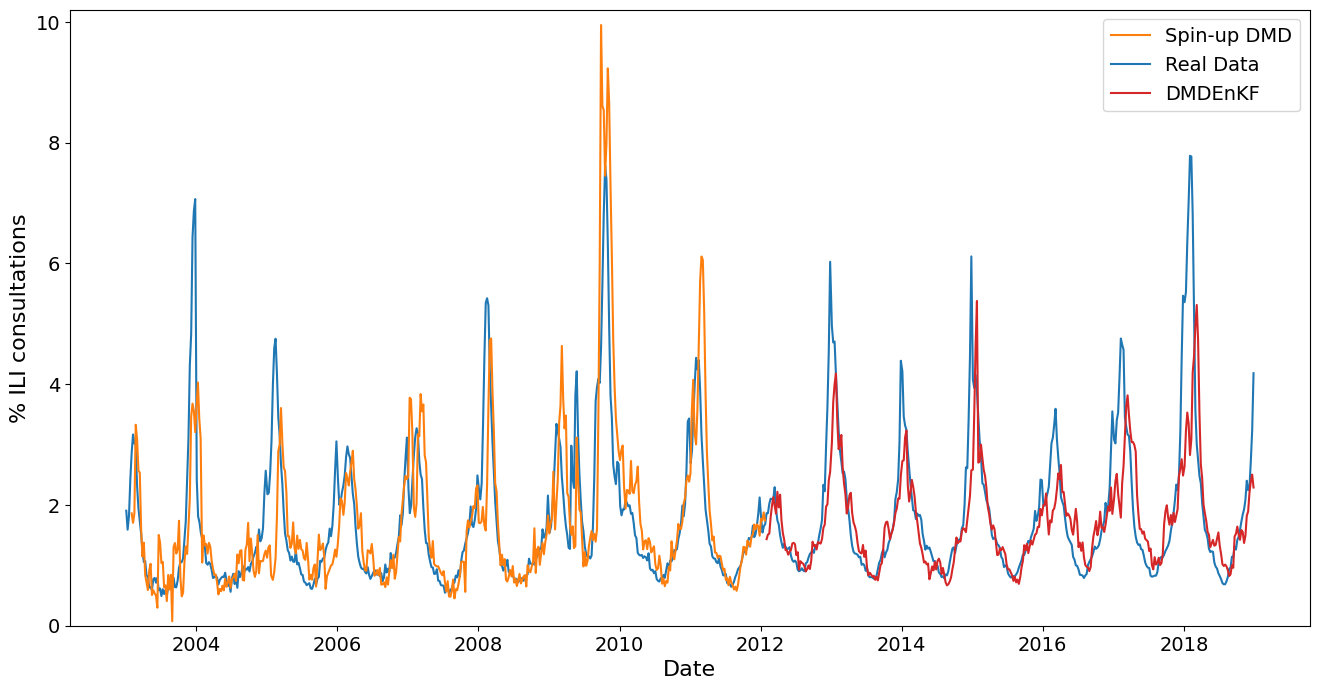

In [10]:
#Plot reconstruction and forecasts over total data

#PLOT SETTINGS
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
scaling = 1
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#DMDEnKF 4 weeks ahead forecast
#ILI consultations as a percentage of the total weekly GP consultations, forecast 4 weeks ahead using the DMDEnKF.

#number of weeks to forecast ahead
weeks_ahead = 4

#create DMD n step ahead predictions
A = f.DMD_modes@np.diag(f.E)@np.linalg.pinv(f.DMD_modes)
predict_operator = np.linalg.matrix_power(A,weeks_ahead)
step_pred = predict_operator@np.hstack(m.spinup_transformed_stratified_data)
step_pred = m.inverse_transform_the_data(step_pred)
step_pred = m.stratified_to_total_data(step_pred,np.hstack(m.spinup_x_values))

#plot n step ahead prediction
plt.plot(np.hstack(m.spinup_x_values)+datetime.timedelta(weeks=weeks_ahead),step_pred,label='Spin-up DMD',color='tab:orange')

#plot real data
plt.plot(df['total data'],color='tab:blue',label='Real Data',zorder=-1)

#plot dmdenkf prediction
plt.plot(df[f'{weeks_ahead} total pred'][df.index >= datetime_to_split],color='tab:red',label='DMDEnKF')

#add plot details
plt.ylabel('% ILI consultations')
plt.xlabel('Date')
plt.legend()
plt.ylim(0,10.2)
#plt.savefig('graphs/dmdenkf_4_weeks_ahead_forecast.png',bbox_inches = 'tight')

### Calculate the log score and mean squared errors over the DMDEnKF's total forecasts

In [11]:
#calculate the log score and mean squared error for the DMDEnKF's total forecasts

#find the accuracy probability over all dates
for weeks_ahead in range(1,n_steps_max+1):
    df[f'{weeks_ahead} total accuracy prob'] = iaf.gen_no_kde_total_accuracy_prob(df['total data'],df[f'{weeks_ahead} ensemble pred'])

#find the accuracy probability over relevant flu seasons
na_free_forecasts = df.dropna()
for weeks_ahead in range(1,n_steps_max+1):
    dmdenkf_score = iaf.calculate_final_probability_score(na_free_forecasts[f'{weeks_ahead} total accuracy prob'])
    print(f'DMDEnKF {weeks_ahead} Forecast: {np.round(dmdenkf_score[0],3)}')

#find the MSE over relevant flu seasons
mses = iaf.MSE_residuals(n_steps_max, na_free_forecasts)
print(f'DMDEnKF MSES: {np.round(mses["dmdenkf"],3)}')

DMDEnKF 1 Forecast: 0.492
DMDEnKF 2 Forecast: 0.38
DMDEnKF 3 Forecast: 0.322
DMDEnKF 4 Forecast: 0.271
DMDEnKF 5 Forecast: 0.23
DMDEnKF 6 Forecast: 0.2
DMDEnKF 7 Forecast: 0.184
DMDEnKF 8 Forecast: 0.168
DMDEnKF 9 Forecast: 0.155
DMDEnKF 10 Forecast: 0.14
DMDEnKF 11 Forecast: 0.13
DMDEnKF 12 Forecast: 0.123
DMDEnKF MSES: [0.326 0.608 0.873 1.164 1.378 1.552 1.7   1.868 1.928 2.107 2.188 2.123]


### Calculate the historical baseline prediction accuracy probability, and those of the DMDEnKF estimates for each age and region

In [12]:
#set max step ahead forecasts to be scored
n_steps_max = 6

#first remove small imag component from ensemble rounding errors to save warnings
for weeks_ahead in range(1,n_steps_max+1):
    df[f'{weeks_ahead} ensemble pred'] = df[f'{weeks_ahead} ensemble pred'].apply(np.real)
    df[f'{weeks_ahead} ensemble strat pred'] = df[f'{weeks_ahead} ensemble strat pred'].apply(np.real)

    
#Historical Baseline Log Scoring
#create ensemble for historical baseline total and stratified
df['total prev year weeks'] = iaf.gen_prev_year_weeks_list(df['total data'],[2009])
df['stratified prev year weeks'] = iaf.gen_prev_year_weeks_list(df['stratified data'],[2009])

#generate a point estimate for hb total infections to use in graphs to reflect new hb
df['total hb point estimate'] = iaf.median_point_estimate(df['total prev year weeks'])

#apply accuracy probability calc over hb ensemble
df['total hb accuracy prob'] = iaf.gen_total_accuracy_prob(df['total data'], df['total prev year weeks'])


#creates an accuracy probability for all steps ahead of the dmdenkf ensemble without using kde
for weeks_ahead in range(1,n_steps_max+1):
    df[f'total dmdenkf {weeks_ahead} accuracy prob'] = iaf.gen_no_kde_total_accuracy_prob(df['total data'],df[f'{weeks_ahead} ensemble pred'])
    
#loop through each age region combo and perform accuracy probability calcs
for age_region_index in range(40):
    print(f'starting age region {age_region_index}...')
    #format correctly a truth target from the stratified data
    target = df['stratified data'].transform(lambda entry: entry[age_region_index])
    #format correctly the hb ensemble preds from those for all 40 regions just down to those for the releveant region
    df[f'age region {age_region_index} hb'] = df['stratified prev year weeks'].transform(iaf.select_age_region,age_region_index=age_region_index)
    #perform required accuracy probability calculations on hb
    df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
    #perform required point estimate calculations on hb
    df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
    for weeks_ahead in range(1,n_steps_max+1):
        #format correctly the ensemble preds from those for all 40 regions just down to those for the releveant region
        df[f'age region {age_region_index} dmdenkf {weeks_ahead} accuracy prob'] = df[f'{weeks_ahead} ensemble strat pred'].transform(iaf.select_age_region,age_region_index=age_region_index)
        #perform required accuracy probability calculations
        df[f'age region {age_region_index} dmdenkf {weeks_ahead} accuracy prob'] = iaf.gen_no_kde_total_accuracy_prob(target, df[f'age region {age_region_index} dmdenkf {weeks_ahead} accuracy prob'])

starting age region 0...


/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")


starting age region 1...
starting age region 2...
starting age region 3...


/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. T

starting age region 4...
starting age region 5...
starting age region 6...
starting age region 7...
starting age region 8...


/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} dmdenkf {weeks_ahead} accuracy prob'] = df[f'{weeks_ahead} ensemble strat pred'].transform(iaf.select_age_region,age_region_index=age_region_index)
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} dmdenkf {weeks_ahead} accuracy prob'] = df[f'{weeks_ahead} ensemble strat pred'].transform(iaf.select_age_region,age_region_index=age_region_index

starting age region 9...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 10...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 11...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 12...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 13...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 14...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 15...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 16...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 17...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 18...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 19...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 20...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 21...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 22...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 23...


/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. T

/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. T

starting age region 24...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 25...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 26...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 27...


/tmp/ipykernel_89386/1355176149.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb'] = df['stratified prev year weeks'].transform(iaf.select_age_region,age_region_index=age_region_index)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

starting age region 28...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 29...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 30...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 31...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 32...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 33...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 34...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 35...


/tmp/ipykernel_89386/1355176149.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb accuracy prob'] = iaf.gen_total_accuracy_prob(target, df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'age region {age_region_index} hb point estimate'] = iaf.median_point_estimate(df[f'age region {age_region_index} hb'])
/tmp/ipykernel_89386/1355176149.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually

starting age region 36...


/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. T

starting age region 37...


/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. T

starting age region 38...


/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. T

starting age region 39...


/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. T

/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. T

/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/KDEpy/bw_selection.py:291: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. T

### Plot the 4-week ahead total forecasts for the DMDEnKF, with 95% confidence interval generated from the ensemble also included

(0.0, 18.0)

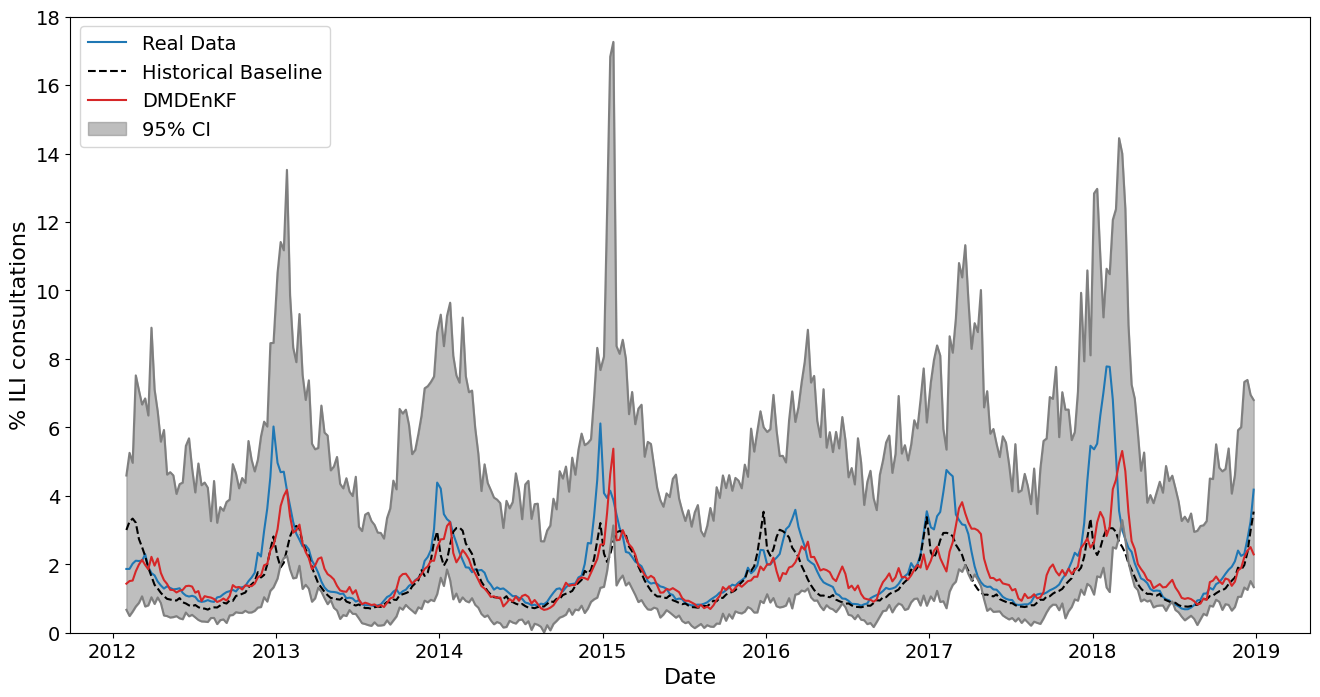

In [13]:
#Plot ILI zoomed in with CI and historical baseline
#ILI consultations as a percentage of the total weekly GP consultations, forecast 4 weeks ahead using the DMDEnKF

#confidence interval percentiles
ci = 0.95

#stps to forecast ahead
n_steps = 4

#plot total data
plt.plot(df['total data'][df.index >= datetime_to_split][n_steps:],color='tab:blue',label='Real Data')

#plot historical baseline using median point estimate from KDE without pandemic year
plt.plot(df['total hb point estimate'][df.index >= datetime_to_split][n_steps:],color='black',label='Historical Baseline',linestyle='--')

#plot dmdenkf total prediction
plt.plot(df[f'{n_steps} total pred'][df.index >= datetime_to_split],color='tab:red',label='DMDEnKF')

#ensemble predictions to be used
ensemble_predicitons = df[f'{n_steps} ensemble pred'][df.index >= datetime_to_split].values

#plot CI
top_ci, bottom_ci, mid = iaf.gen_ensemble_ci(ci,ensemble_predicitons)
plt.plot(df.index[df.index >= datetime_to_split],top_ci,color='tab:grey')
plt.plot(df.index[df.index >= datetime_to_split],bottom_ci,color='tab:grey')
plt.fill_between(df.index[df.index >= datetime_to_split],top_ci,bottom_ci,color='tab:grey',alpha=0.5,label=f'{round(ci*100)}% CI')

#add plot details
plt.ylabel('% ILI consultations')
plt.xlabel('Date')
plt.legend()
plt.ylim(0,18)
#plt.savefig('graphs/ILI_zoomedin_withCI.png',bbox_inches='tight')

### Calculate the final log scores (as used in previous ILINet competitions) and MSE's for each total forecast, then display them

In [14]:
#calculate and print all final scores for DMDEnKF and HB

#drop nan rows, restrict to relevant flu seasons and the calculate final log scores for total predictions (dmdenkf and hb)
na_free_forecasts = df.dropna()
hb_score = iaf.calculate_final_probability_score(na_free_forecasts['total hb accuracy prob'])
print('LOG SCORES')
print(f'Historical Baseline: {hb_score[0]}')
for weeks_ahead in range(1,n_steps_max+1):
    dmdenkf_score = iaf.calculate_final_probability_score(na_free_forecasts[f'total dmdenkf {weeks_ahead} accuracy prob'])
    print(f'DMDEnKF {weeks_ahead} Forecast: {dmdenkf_score[0]}')

#calculate final log scores for each age region (dmdenkf and hb)
hb_region_scores = [iaf.calculate_final_probability_score(na_free_forecasts[f'age region {age_region_index} hb accuracy prob'])[0] for age_region_index in range(40)]
dmdenkf_region_scores = {}
for weeks_ahead in range(1,n_steps_max+1):
    dmdenkf_region_scores[weeks_ahead] = np.array([iaf.calculate_final_probability_score(na_free_forecasts[f'age region {age_region_index} dmdenkf {weeks_ahead} accuracy prob'])[0] for age_region_index in range(40)])

#calculate/print MSE's at total level
print('MSE')
mses = iaf.MSE_residuals_with_hb(m,n_steps_max,df)
print(f'Historical Baseline: {mses["hb"]}')
print(f'DMDEnKF: {mses["dmdenkf"]}')

#calculate MSE for each region of hb and DMDEnKF
#restrict df as required to relevant flu seasons
forecast_df = iaf.restrict_flu_season(df)

#correctly format hb and DMDEnKF strat estimates
hb_pes = np.vstack([forecast_df[f'age region {age_region_index} hb point estimate'].values for age_region_index in range(40)])
true_strat = np.vstack(forecast_df['stratified data'].values).T

#calc mse for strat hb and save as array
strat_mse_hb = np.array([mean_squared_error(true_reg,hb_reg) for true_reg,hb_reg in zip(true_strat,hb_pes)])
strat_mse_dmdenkf = {}
for weeks_ahead in range(n_steps_max):
    dmdenkf_pes = np.vstack(forecast_df[f'{weeks_ahead + 1} strat pred'].values).T
    strat_mse_dmdenkf[weeks_ahead+1] = np.array([mean_squared_error(true_reg,np.real(hb_reg)) for true_reg,hb_reg in zip(true_strat,dmdenkf_pes)])

LOG SCORES
Historical Baseline: 0.2787680156124525
DMDEnKF 1 Forecast: 0.4921922303136035
DMDEnKF 2 Forecast: 0.37954207310676297
DMDEnKF 3 Forecast: 0.3215744624571249
DMDEnKF 4 Forecast: 0.27141039356978347
DMDEnKF 5 Forecast: 0.22978171580975518
DMDEnKF 6 Forecast: 0.19987890169333006
MSE
Historical Baseline: 1.243102375093871
DMDEnKF: [0.3255846201157636, 0.6078497820557702, 0.8730712463314239, 1.164360126046119, 1.3784662766771176, 1.5515628096565002]


### Plot the log scores for each age and region in the DMDEnKF's 4-week ahead forecast as a heatmap

Text(0.5, 43.7222222222222, 'Regions')

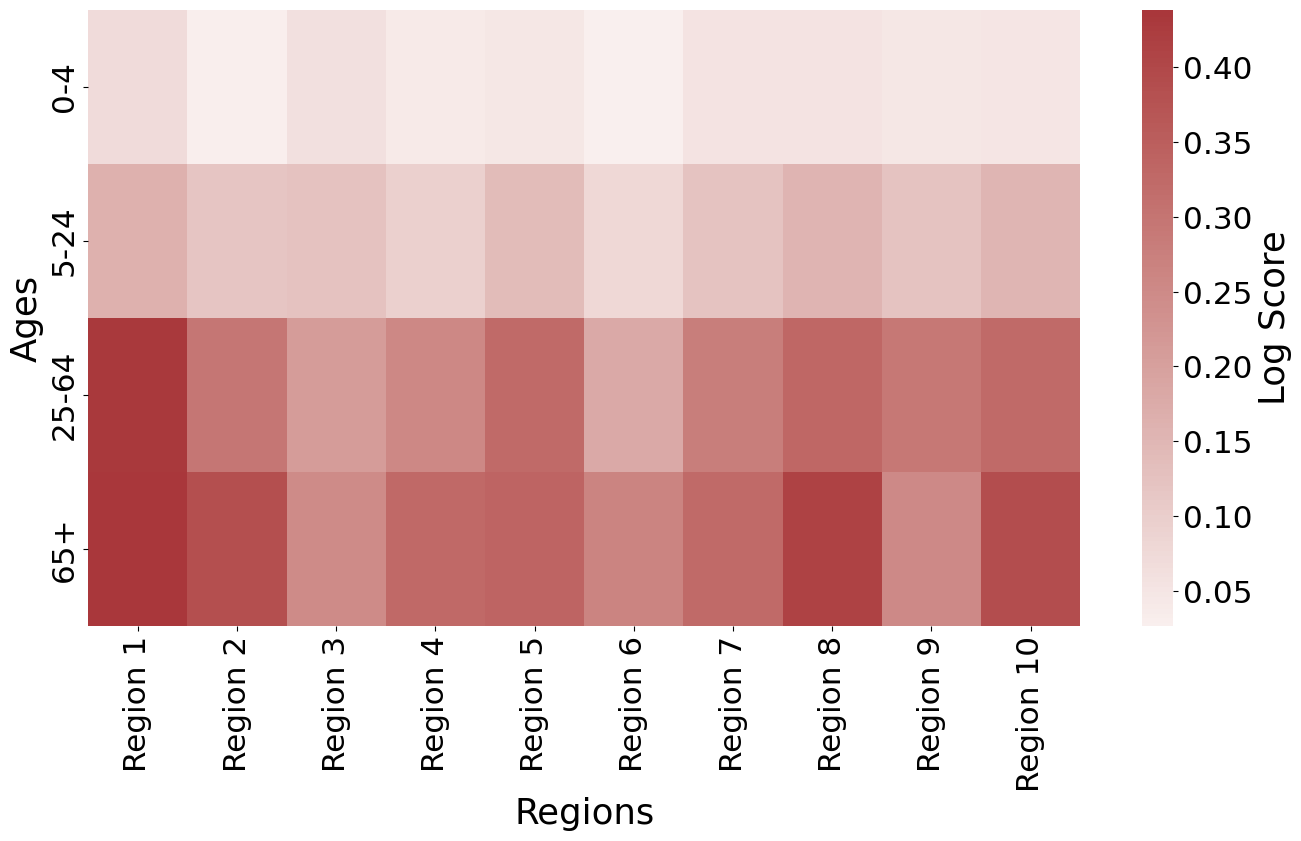

In [15]:
#Age region dmdenkf log scores heatmap
#Log score for 4 step ahead DMDEnKF forecast.

plt.rcParams["figure.figsize"] = (16,8) # (w, h)
scaling = 1.6
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

n_steps = 4
fig, ax = plt.subplots(nrows=1,sharey=True,sharex=True)
regions = ['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5',
           'Region 6', 'Region 7', 'Region 8', 'Region 9', 'Region 10']
ages = ['0-4', '5-24', '25-64', '65+']
yticks = ages
xticks = regions
reg_score = dmdenkf_region_scores[n_steps]
sb.heatmap(np.reshape(reg_score,(10,4)).T,cmap='vlag',center=0,xticklabels=xticks,yticklabels=yticks,cbar_kws={'label': 'Log Score'})
plt.ylabel('Ages')
plt.xlabel('Regions')
#plt.savefig('graphs/age_region_dmdenkf_log_scores.png',bbox_inches='tight')

### Plot the log scores for each age and region in the DMDEnKF's 4-week ahead forecast with the scores of the historical baseline prediction subtracted as a heatmap

Text(0.5, 43.7222222222222, 'Regions')

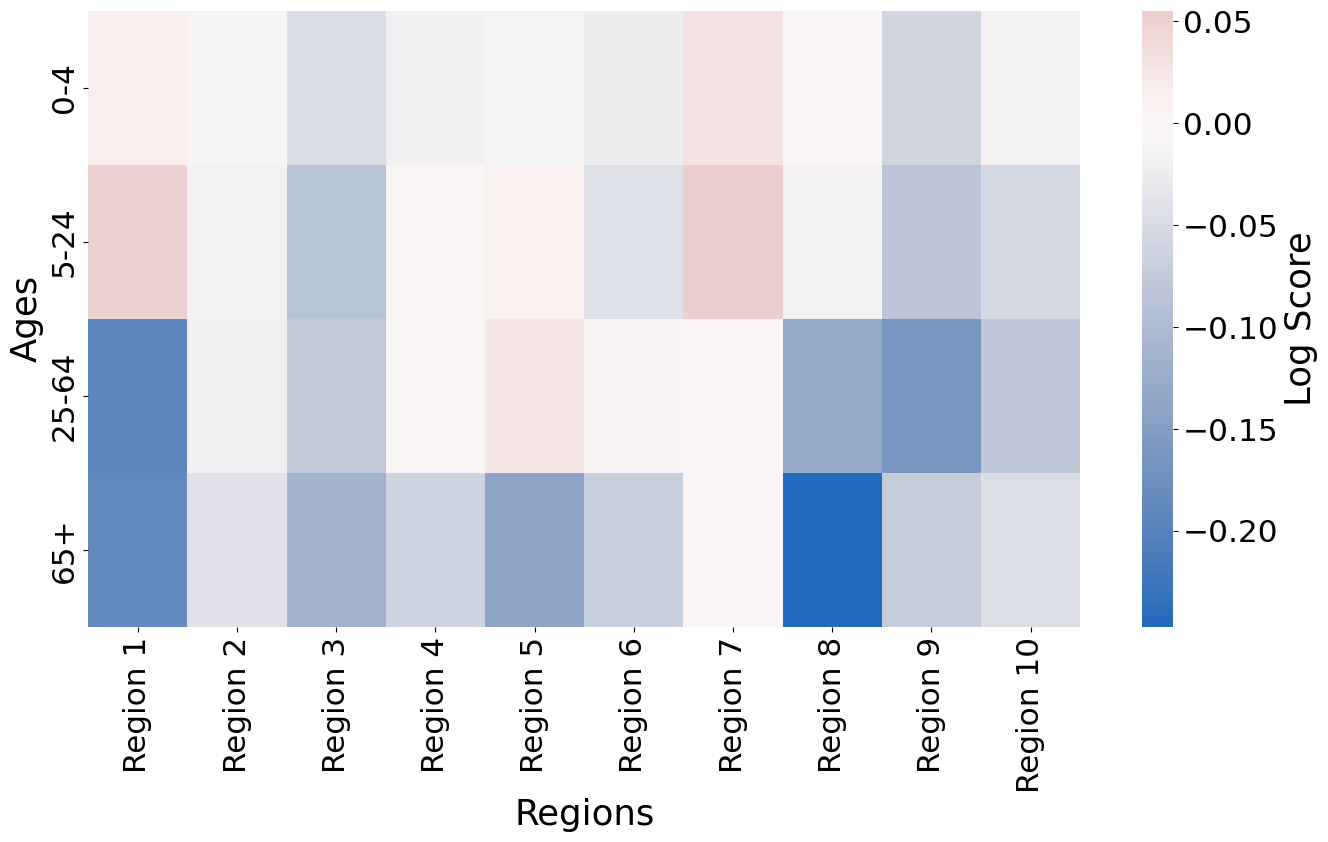

In [16]:
#Age region dmdenkf - hb log scores
#Log score for 4 step ahead DMDEnKF forecast with historical baseline scores subtracted.

fig, ax = plt.subplots(nrows=1,sharey=True,sharex=True)
regions = ['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5',
           'Region 6', 'Region 7', 'Region 8', 'Region 9', 'Region 10']
ages = ['0-4', '5-24', '25-64', '65+']
yticks = ages
xticks = regions
reg_score = dmdenkf_region_scores[n_steps] - hb_region_scores
sb.heatmap(np.reshape(reg_score,(10,4)).T,cmap='vlag',center=0,xticklabels=xticks,yticklabels=yticks,cbar_kws={'label': 'Log Score'})
plt.ylabel('Ages')
plt.xlabel('Regions')
#plt.savefig('graphs/age_region_dmdenkf_subhb_log_scores.png',bbox_inches='tight')

### Plot both of the above graphs next to each other for convenience

Text(0.08, 0.5, 'Ages')

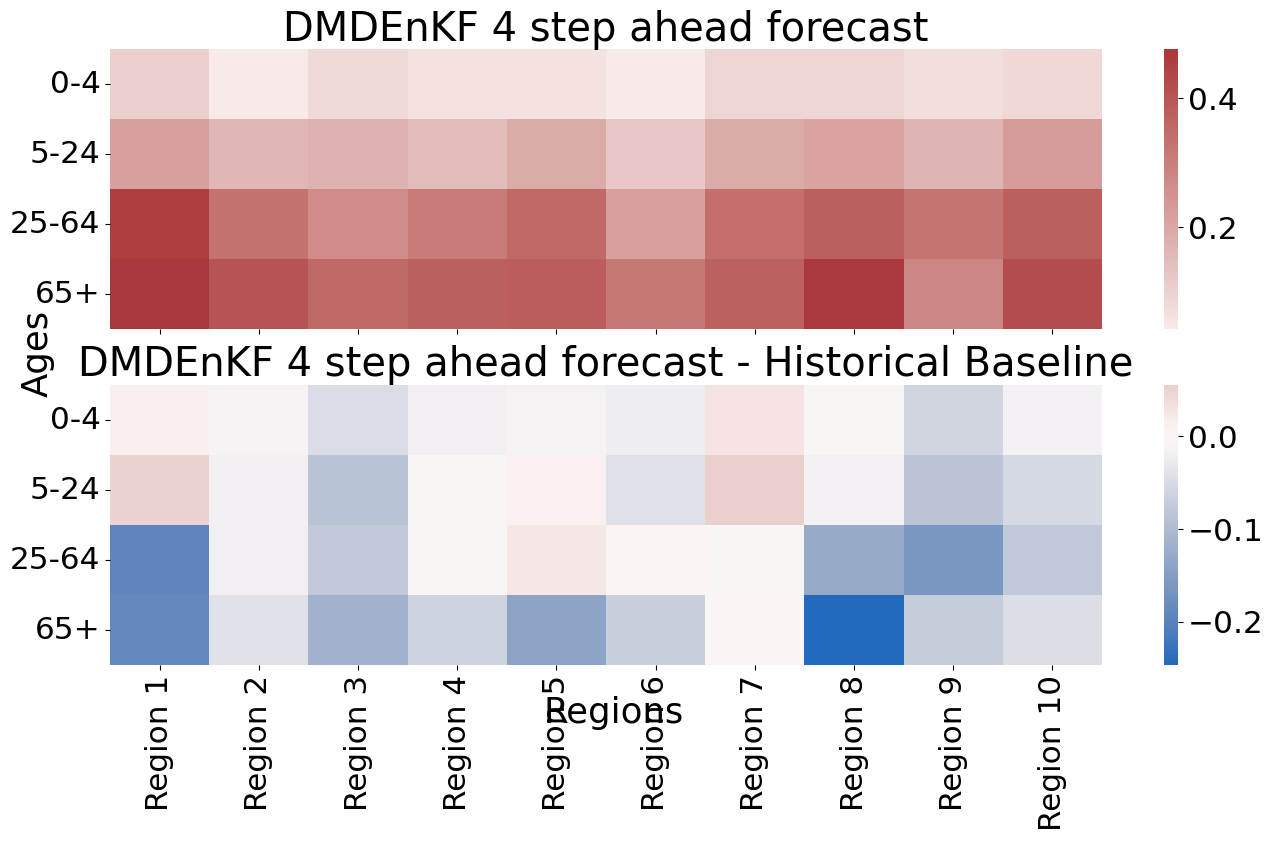

In [17]:
#Joint plot for DMDEnKF age/region log scores with and without normalising by historical baseline

fig, ax = plt.subplots(nrows=2,sharey=True,sharex=True)
regions = ['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5',
           'Region 6', 'Region 7', 'Region 8', 'Region 9', 'Region 10']
ages = ['0-4', '5-24', '25-64', '65+']
yticks = ages
xticks = regions

reg_score = dmdenkf_region_scores[1]
sb.heatmap(np.reshape(reg_score,(10,4)).T,cmap='vlag',center=0,ax=ax[0],xticklabels=xticks,yticklabels=yticks)
ax[0].title.set_text('DMDEnKF 4 step ahead forecast')
reg_score = dmdenkf_region_scores[n_steps] - hb_region_scores
sb.heatmap(np.reshape(reg_score,(10,4)).T,cmap='vlag',center=0,xticklabels=xticks,yticklabels=yticks)
ax[1].title.set_text('DMDEnKF 4 step ahead forecast - Historical Baseline')
fig.text(0.44, 0.05, 'Regions', ha='center', va='center',size=MEDIUM_SIZE)
fig.text(0.08, 0.5, 'Ages', ha='center', va='center', rotation='vertical',size=MEDIUM_SIZE)
#plt.savefig('graphs/age_region_log_scores.png',bbox_inches='tight')

### Compare different rank truncations for the DMDEnKF, and calculate the log scores and MSE's of these alternative models with r = 4, ... ,12

In [18]:
#DIFFERNT TRUNCATION RANK COMPARISONS

#set random seed and initialise storage dictionairy
np.random.seed(0)
rank_dmdenkf_results = {}

#for all ranks in chosen range
ranks = list(range(4,13))
for rank in ranks:
    
    #set relevant modelling choice parameters
    logtrans = LogTransform(constant=logconst)
    data_transform = logtrans
    n_steps_max = 4


    #Train and run filter over the data

    #initialise modelling choices object - children classes used to modularise new methodological variations
    m = ModellingChoices(data_transform=data_transform, pandemic_years=pandemic_years,flu_season=flu_season)

    #prepare the data in a way determined by the above parameters and split to spin up/filter
    m.prepare_data(data,disease,datetime_to_split,hankel_dim=hankel_dim)

    #initialise and run TDMD on spin up data that comes in discontinuous form
    f = TDMD()
    f.fit(data=m.spinup_transformed_stratified_data,datatype='discontinuous',r=rank)

    #run the filter over the rest of the data, carrying the eigenvalue estimates over from each discontinuous section
    m.filter_all_sections(f,eig_carry=True,sys_obs_rat=sys_obs_rat,sys_eig_rat=sys_eig_rat, sys_cov_rat=sys_cov_rat)

    #set relevant variables names using modelling choices object
    dmdenkf = m.dmdenkf_container['full_filters'][0]
    #forecast using the DMDEnKF
    df = iaf.generate_forecast_df(dmdenkf,m,n_steps_max)

    n_steps_max = 4
    
    #use the forecast to generate log and mean squared error scores for dmdenkf and hb
    
    #first remove small imag component from ensemble rounding errors to save warnings
    for weeks_ahead in range(1,n_steps_max+1):
        df[f'{weeks_ahead} ensemble pred'] = df[f'{weeks_ahead} ensemble pred'].apply(np.real)
        df[f'{weeks_ahead} ensemble strat pred'] = df[f'{weeks_ahead} ensemble strat pred'].apply(np.real)


    #Historical Baseline Log Scoring
    #create ensemble for historical baseline total and stratified
    df['total prev year weeks'] = iaf.gen_prev_year_weeks_list(df['total data'],[2009])
    df['stratified prev year weeks'] = iaf.gen_prev_year_weeks_list(df['stratified data'],[2009])

    #generate a point estimate for hb total infections to use in graphs to reflect new hb
    df['total hb point estimate'] = iaf.median_point_estimate(df['total prev year weeks'])

    #apply accuracy probability calc over hb ensemble
    df['total hb accuracy prob'] = iaf.gen_total_accuracy_prob(df['total data'], df['total prev year weeks'])


    #creates an accuracy probability for all steps ahead of the dmdenkf ensemble without using kde
    for weeks_ahead in range(1,n_steps_max+1):
        df[f'total dmdenkf {weeks_ahead} accuracy prob'] = iaf.gen_no_kde_total_accuracy_prob(df['total data'],df[f'{weeks_ahead} ensemble pred'])



    #drop nan rows, restrict to relevant flu seasons and the calculate final log scores for total predictions (dmdenkf and hb)
    na_free_forecasts = df.dropna()
    hb_score = iaf.calculate_final_probability_score(na_free_forecasts['total hb accuracy prob'])
    #calculate scores for each forecast horizon
    logscores = []
    for weeks_ahead in range(1,n_steps_max+1):
        dmdenkf_score = iaf.calculate_final_probability_score(na_free_forecasts[f'total dmdenkf {weeks_ahead} accuracy prob'])
        logscores.append(dmdenkf_score[0])

    #calculate MSE at national level
    mses = iaf.MSE_residuals_with_hb(m,n_steps_max,df)

    #return final eigs, log scores and MSE's using the rank as a key
    rank_dmdenkf_results[rank] = {'eigs':f.E ,'logscores':logscores, 'mses':mses['dmdenkf']}

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


2


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


3


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


4


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


2


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


3


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


4


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


2


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


3


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


4


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


2


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


3


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


4


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


2


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


3


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


4


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


2


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


3


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


4


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


2


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


3


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


4


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


2


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


3


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


4


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


2


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


3


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


4


/home/falconical/Documents/PHD/trevspace/dmdenkf/DMDEnKF/helper_functions/ili_applications_functions.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  one_step_forward_ens = ((dmdenkf.DMD.DMD_modes@(one_step_forward_ens.T)).T).astype('float32')


### Plot the eigenvalues in the spin-up DMD processes for r = 4, and r = 12

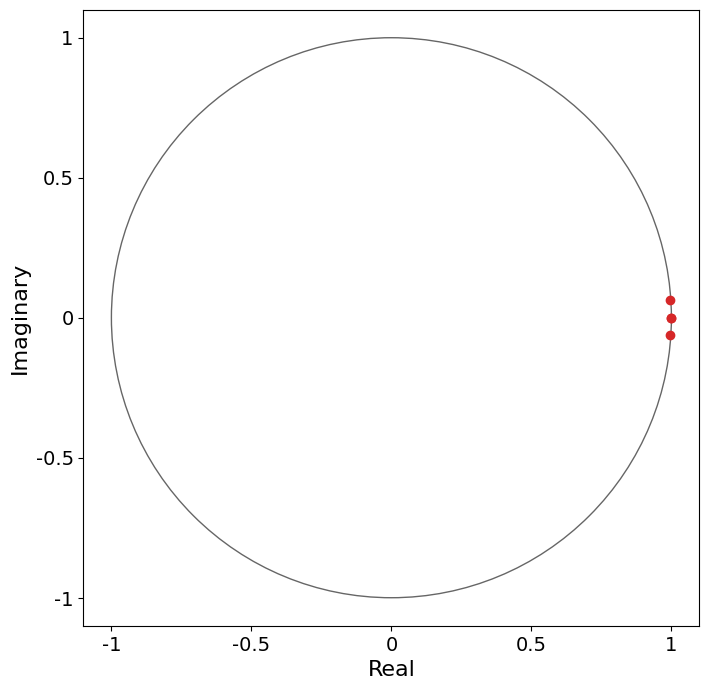

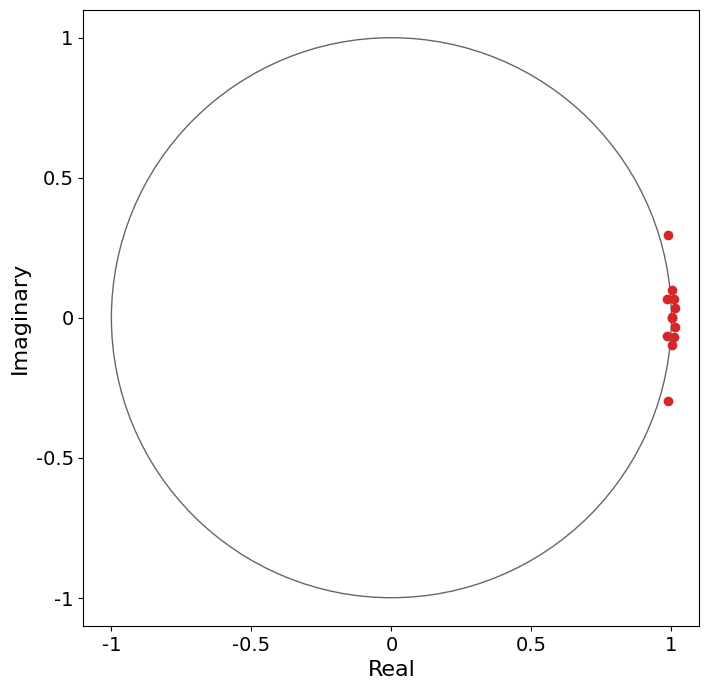

In [19]:
#create a plot showing the eigs of the spin-up DMD for r = 4, and r = 12

#PLOT SETTINGS
plt.rcParams["figure.figsize"] = (8,8) # (w, h)
scaling = 1
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Spinup Eigs
#Eigenvalues generated by the spin up DMD of differing ranks.

#extract just the eigs from the dictionairy
rank_eigs = [v['eigs'] for v in rank_dmdenkf_results.values()]
#restrict to just the largest and ranks
rank_eigs = [rank_eigs[i] for i in [0,-1]]

#plot the eigs on a complex plane
for r,rank_eig in zip([4,12],rank_eigs):
    iaf.gen_eigenvalue_plots(rank_eig)
    #plt.savefig(f'graphs/{r}spinup_eigs.png',bbox_inches='tight')

### Line graph showing how log scores and MSE's change for 4-week ahead forecasts as truncation rank is varied between r = 4 and r=12

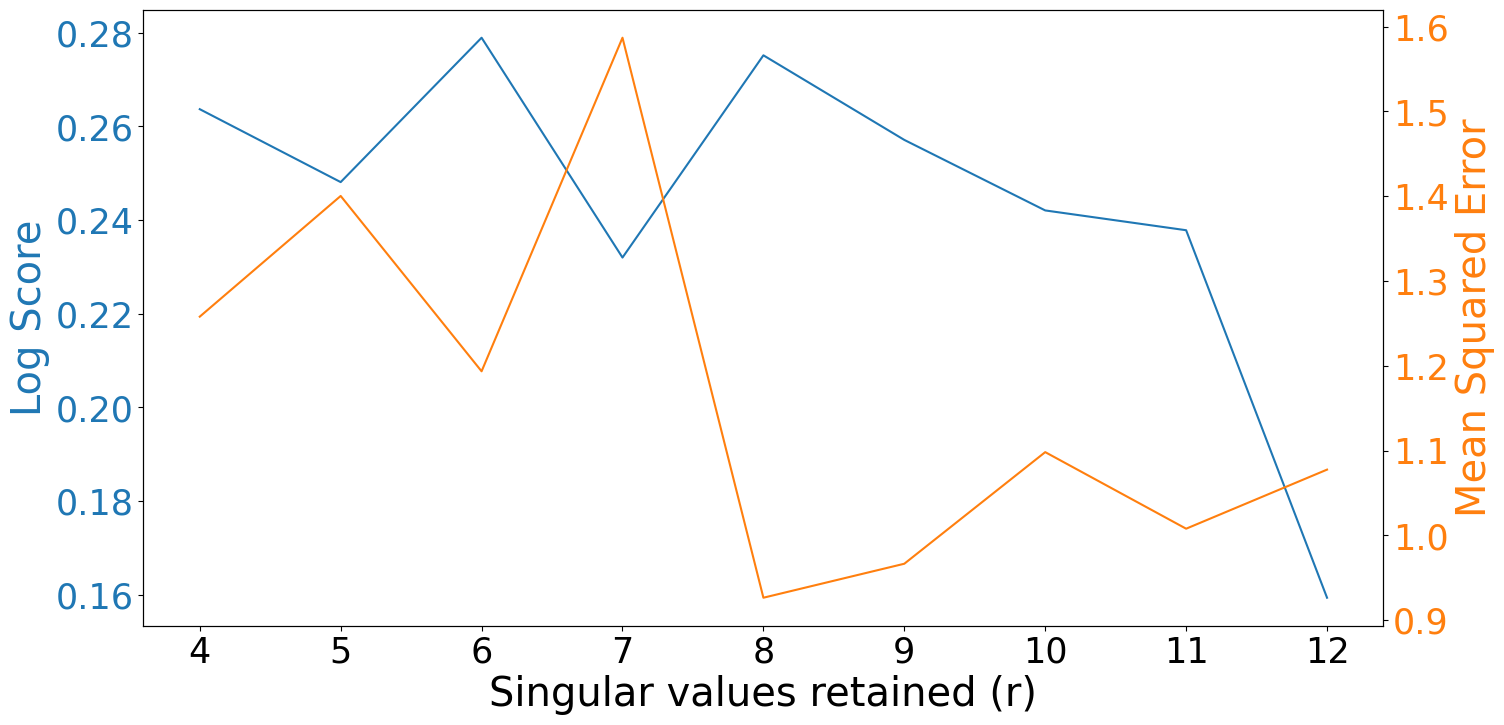

In [20]:
#plot how log score and mse decrease with increasing rank for 4 step ahead prediction

#PLOT SETTINGS
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
scaling = 1.8
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#extract 4 step ahead prediction scores
logscores_4step = [v['logscores'][-1] for v in rank_dmdenkf_results.values()]
mses_4step = [v['mses'][-1] for v in rank_dmdenkf_results.values()]

#create log score plot
fig, ax = plt.subplots()
c = 'tab:blue'
plt.plot(ranks,logscores_4step, color=c)
plt.xlabel('Singular values retained (r)')
plt.ylabel('Log Score',color=c)
ax.tick_params(axis='y', labelcolor=c)

#add mse plot
ax=ax.twinx()
c = 'tab:orange'
plt.plot(ranks,mses_4step,color=c)
plt.ylabel('Mean Squared Error',color=c)
ax.tick_params(axis='y', labelcolor=c)
#plt.savefig(f'graphs/rank_errors.png',bbox_inches='tight')

###  Bubble plot showing how log scores and MSE's change for 4-week ahead forecasts as truncation rank is varied between r = 4 and r=12

Text(0.5, 0, 'Log Score')

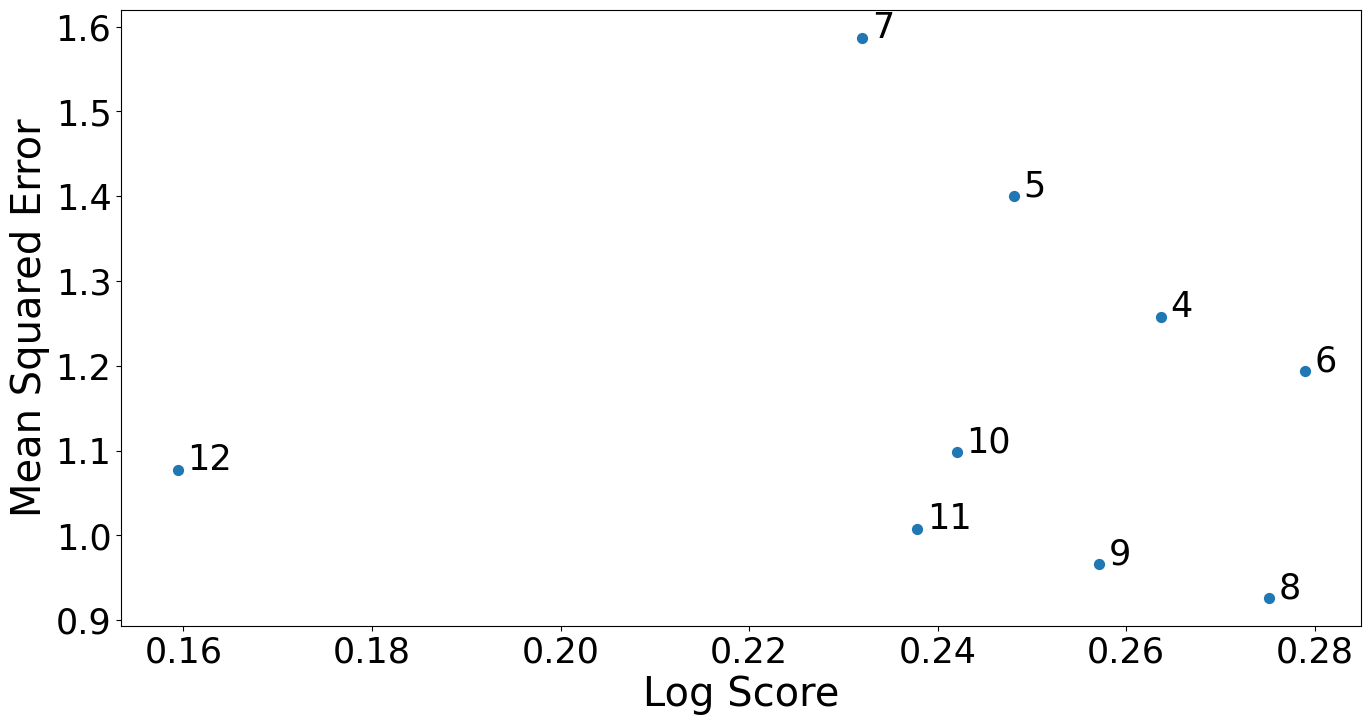

In [21]:
#create bubble plot of how logscore and mse are effected by changing rank

#extract 4 step ahead log score/mse's
logscores_4step = [v['logscores'][-1] for v in rank_dmdenkf_results.values()]
mses_4step = [v['mses'][-1] for v in rank_dmdenkf_results.values()]

#create plot
fig, ax = plt.subplots()
c = 'tab:blue'

#add scatter points
plt.scatter(logscores_4step,mses_4step, color=c,s=50)
for i, txt in enumerate(ranks):
    ax.annotate(txt, (logscores_4step[i]+0.001, mses_4step[i]))

#add plot details
plt.ylabel('Mean Squared Error')
plt.xlabel('Log Score')
#plt.savefig(f'graphs/bubble_rank_errors.png',bbox_inches='tight')

### Plot how the variance captured in the data changes as the number of singular values retained is varied

Text(8.5, 0.65, 'Rank cut off \n at r=8.')

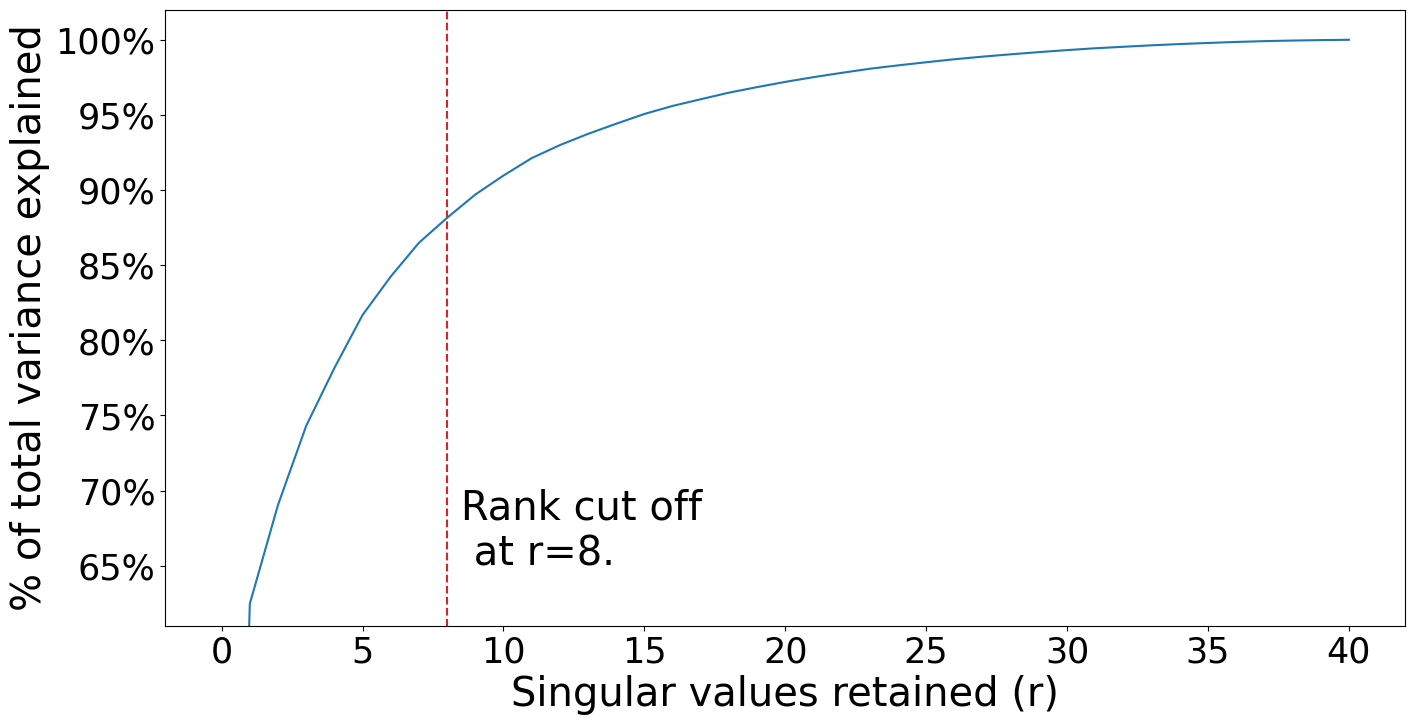

In [22]:
#create plot showing how variance in the data is captured by retaining more PCA modes, aka changing rank truncation

#apply PCA to the spinup data
p = PCA()
real_data = np.hstack(m.spinup_transformed_stratified_data)
p.fit(real_data.T)

#store cumulative variance retained with each mode
l = [0]
l.extend(np.cumsum(p.explained_variance_ratio_))

#create plot
plt.plot(l)

#add plot details
plt.xlabel('Singular values retained (r)')
plt.ylabel('% of total variance explained')
plt.yticks([0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],['65%','70%','75%','80%','85%','90%','95%','100%'])
plt.ylim(0.61,1.02)
plt.vlines(8,-1,2,zorder=-1,color='tab:red',linestyle='dashed')
plt.annotate('Rank cut off \n at r=8.',[8 + 0.5,0.65],size=MEDIUM_SIZE)
#plt.savefig('graphs/svd_variance_elbow.png',bbox_inches='tight')